In [304]:
from typing import List, Dict, Union, Optional, Tuple

In [305]:
import qiskit as qk
import qiskit.quantum_info as qi
import qiskit.circuit as qc
from qiskit.providers import aer

In [306]:
from math import pi, log2
from random import random

In [307]:
import numpy as np

# Utilities

In [308]:
def unique_param() -> qc.Parameter:
    unique_param.counter += 1
    return qc.Parameter(f"${unique_param.counter}")
unique_param.counter = 0

In [309]:
unique_param()

Parameter($1)

In [310]:
def ilog2(x) -> int:
    return int(log2(x))
def arr_qubits(x: np.array):
    return ilog2(len(x))

In [311]:
def rand2pi() -> float:
    return random() * 2 * pi

In [312]:
rand2pi()

4.667232879225646

In [313]:
iYgate=qk.extensions.UnitaryGate(data=[[0, 1.j], [-1.j, 0]])
ciYgate=iYgate.control(label="iY")

# Variational Forms

In [323]:
def new_circuit(width: int) -> qc.QuantumCircuit:
    circ = qc.QuantumCircuit(width)
    return circ
def empty_circuit_like(circ: qc.QuantumCircuit) -> qc.QuantumCircuit:
    return circ.QuantumCircuit(*circ.qregs, *circ.cregs)

## Unitary Layer

In [324]:
def unitary_layer(width: int) -> qc.QuantumCircuit:
    circ = new_circuit(width)
    for qubit in circ.qubits:
        circ.u3(unique_param(), unique_param(), unique_param(), qubit)
    return circ

In [325]:
unitary_layer(3).draw()

┌──────────────┐
q_0: ─┤ U3($2,$3,$4) ├
      ├──────────────┤
q_1: ─┤ U3($5,$6,$7) ├
     ┌┴──────────────┤
q_2: ┤ U3($8,$9,$10) ├
     └───────────────┘

## Entangling Layer

In [326]:
def entangling_layer(width: int, offset: int)-> qc.QuantumCircuit:
    circ = qc.QuantumCircuit(width)
    for i in range(0, circ.num_qubits-1, 2):
        idx_a = (i+offset) % circ.num_qubits
        idx_b = (i+1+offset) % circ.num_qubits
        circ.cz(idx_a, idx_b)
    return circ

In [327]:
entangling_layer(12, 1).draw()

q_0: ────■─
          │ 
 q_1: ─■──┼─
       │  │ 
 q_2: ─■──┼─
          │ 
 q_3: ─■──┼─
       │  │ 
 q_4: ─■──┼─
          │ 
 q_5: ─■──┼─
       │  │ 
 q_6: ─■──┼─
          │ 
 q_7: ─■──┼─
       │  │ 
 q_8: ─■──┼─
          │ 
 q_9: ─■──┼─
       │  │ 
q_10: ─■──┼─
          │ 
q_11: ────■─

In [328]:
(unitary_layer(4) + entangling_layer(4, 0)).draw()

┌─────────────────┐   
q_0: ┤ U3($11,$12,$13) ├─■─
     ├─────────────────┤ │ 
q_1: ┤ U3($14,$15,$16) ├─■─
     ├─────────────────┤   
q_2: ┤ U3($17,$18,$19) ├─■─
     ├─────────────────┤ │ 
q_3: ┤ U3($20,$21,$22) ├─■─
     └─────────────────┘

## Postselection Gadget Layer

This is a simple RUS circuit from arxiv.org/abs/1711.11240.
As this is a RUS circuit, the postselection can be done efficiently.

In [411]:
PSGADGET_ANCILLA_QREG = qc.QuantumRegister(1, "q_{ps}")
PSGADGET_ANCILLA_CREG = qc.ClassicalRegister(1, "c_{ps}")

def postsel_gadget_layer(width: int, inlanes: List[int], outlane: int, add_measurement: bool = False) -> qc.QuantumCircuit:    
    circ = new_circuit(width)
    circ.add_register(PSGADGET_ANCILLA_QREG)
    
    params = [ unique_param() for _ in inlanes ]
    
    # always apply (static) correction before RUS circuit so that we can simply repeat it
    circ.rz(-pi/2, circ.qubits[outlane])
    
    # RUS circuit
    for i, lane in enumerate(inlanes):
        circ.cry(params[i], circ.qubits[lane], PSGADGET_ANCILLA_QREG[0])
    circ.cy(PSGADGET_ANCILLA_QREG[0], circ.qubits[outlane])
    circ.rz(-pi/2, PSGADGET_ANCILLA_QREG[0])
    for i, lane in reversed(list((enumerate(inlanes)))):
        circ.cry(-params[i], circ.qubits[lane], PSGADGET_ANCILLA_QREG[0])
        
    # measurement
    if add_measurement:
        circ.add_register(PSGADGET_ANCILLA_CREG)
        circ.measure(PSGADGET_ANCILLA_QREG[0], PSGADGET_ANCILLA_CREG[0])
    
    return circ

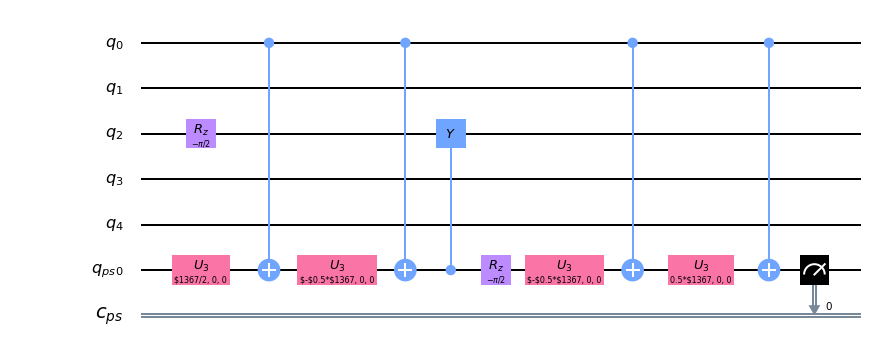

In [412]:
postsel_gadget_layer(5, [0], 2, add_measurement=True).draw(output="mpl")

In [450]:
def postselect(psi: qi.Statevector, qubit_idx: int, what: int = 0, flip_threshold: float = 1e-6) -> qi.Statevector:
    """
        postselect on a measurement outcome;
        if postselection_probability is below the threshold, we postselect on the complement
    """
    qubit_idx %= psi.num_qubits
    
    p = psi.probabilities([qubit_idx])
    
    if p[what] < flip_threshold:
        what = 1-what
    
    proj = np.zeros(2, dtype=complex)
    proj[what] = 1 / np.sqrt(p[what])
    
    return psi.evolve(qi.Operator(np.diag(proj), input_dims=2, output_dims=2), qargs=[qubit_idx])

In [451]:
foo = unitary_layer(3) + postsel_gadget_layer(3, [0], 2, add_measurement=False)
foo = foo.bind_parameters({ p: rand2pi() for p in foo.parameters })
phi = qi.Statevector.from_instruction(foo)
postselect(phi, -1, 1)

Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              6.88972021e-17-5.38259392e-19j,
             -6.15228979e-02-9.56220044e-03j,
             -1.37794404e-16+0.00000000e+00j,
              1.68491152e-01-2.07835189e-01j,
              0.00000000e+00-5.38259392e-19j,
             -2.15681911e-01-3.12344564e-02j,
              0.00000000e+00+0.00000000e+00j,
              5.82184822e-01-7.33556622e-01j],
            dims=(2, 2, 2, 2))

## Output Layer

In the actual algorithm, we would run a number of rnn's in parallel, sampling from the distributions to estimate them. Note that we still evolve forward by

In [335]:
OUT_CREG_NAME = "c_{out}"
def output_layer(width: int, outcount: int) -> qc.QuantumCircuit:
    """
        Measure the first outcount lanes
    """
    circ = qc.QuantumCircuit(width)
    circ.add_register(qc.ClassicalRegister(outcount, OUT_CREG_NAME))
    circ.measure(circ.qubits[:outcount], circ.clbits[:outcount])
    
    return circ

In [336]:
output_layer(5, 3).draw()

┌─┐      
      q_0: ┤M├──────
           └╥┘┌─┐   
      q_1: ─╫─┤M├───
            ║ └╥┘┌─┐
      q_2: ─╫──╫─┤M├
            ║  ║ └╥┘
      q_3: ─╫──╫──╫─
            ║  ║  ║ 
      q_4: ─╫──╫──╫─
            ║  ║  ║ 
c_{out}_0: ═╩══╬══╬═
               ║  ║ 
c_{out}_1: ════╩══╬═
                  ║ 
c_{out}_2: ═══════╩═

In [337]:
def cheating_output_layer(psi: qi.Statevector, outcount: int) -> Tuple[str, qi.Statevector, np.ndarray]:
    return (*psi.measure(range(outcount)), psi.probabilities(range(outcount)))

In [339]:
foo = unitary_layer(3)
foo = foo.bind_parameters({ p: rand2pi() for p in foo.parameters })
phi = qi.Statevector.from_instruction(foo)
phi

Statevector([ 0.14964069+0.j        ,  0.02068113-0.34418956j,
              0.25398991+0.22373545j,  0.54971813-0.55328248j,
             -0.05746372+0.01475293j,  0.02599152+0.13421161j,
             -0.11959285-0.06087633j, -0.15655041+0.26666288j],
            dims=(2, 2, 2))

In [353]:
cheating_output_layer(phi, 2)

('11',
 Statevector([ 0.        +0.j        ,  0.        +0.j        ,
               0.        +0.j        ,  0.6552028 -0.6594511j ,
               0.        +0.j        ,  0.        +0.j        ,
               0.        +0.j        , -0.18659065+0.31783246j],
             dims=(2, 2, 2)),
 array([0.02591207, 0.13758248, 0.1325768 , 0.70392865]))

## Input Layer

We assume the inputs have been measured, i.e. are either initialized to 0 or are preceded by an output layer which measures them.

In [356]:
def input_layer(width: int, target_content: List[int], outlane_content: List[int]) -> qc.QuantumCircuit:
    """
        Reset the first #target_content lanes
    """
    circ = qc.QuantumCircuit(width)
    for i, (tar, cur) in enumerate(zip(target_content, outlane_content)):
        if tar != cur:
            circ.x(circ.qubits[i])
    return circ

In [357]:
input_layer(6, [1, 1, 0, 1], [0, 0, 0, 0]).draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          
q_5: ─────

In [358]:
input_layer(6, [1, 1, 0, 1], [0, 1, 1, 1]).draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────
          
q_5: ─────

# RVQE Circuit

## Initialization

In [359]:
def rvqe_init(width: int) -> qi.Statevector:
    """
        return all zero state on width+1 qubits
    """
    return qi.Statevector.from_label("0" * (width+1))

In [361]:
rvqe_init(3)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))

## Cell

In [378]:
def rvqe_cell(
    width: int,
    gadget_inlanes: List[int],
    gadget_outlane: int,
    target_content: List[int],
    outlane_content: Optional[List[int]] = None,
    include_barriers: bool = False
) -> Tuple[qc.QuantumCircuit]:
    qc_a = new_circuit(width)
    
    # fix input
    qc_a += input_layer(width, target_content, outlane_content if outlane_content is not None else [0 for _ in target_content])
    include_barriers and qc_a.barrier()
    
    # unitary layers    
    qc_a += unitary_layer(width)
    qc_a += entangling_layer(width, 0)
    include_barriers and qc_a.barrier() 
    qc_a += unitary_layer(width)
    qc_a += entangling_layer(width, 1)
    include_barriers and qc_a.barrier()
    qc_a += unitary_layer(width)
    qc_a += entangling_layer(width, 0)
    include_barriers and qc_a.barrier()
    
    # RUS phase    
    qc_ps = postsel_gadget_layer(width, gadget_inlanes, gadget_outlane)
    include_barriers and qc_ps.barrier()
    
    # output phase
    qc_out = output_layer(width, len(target_content))
    
    return (qc_a, qc_ps, qc_out)
    

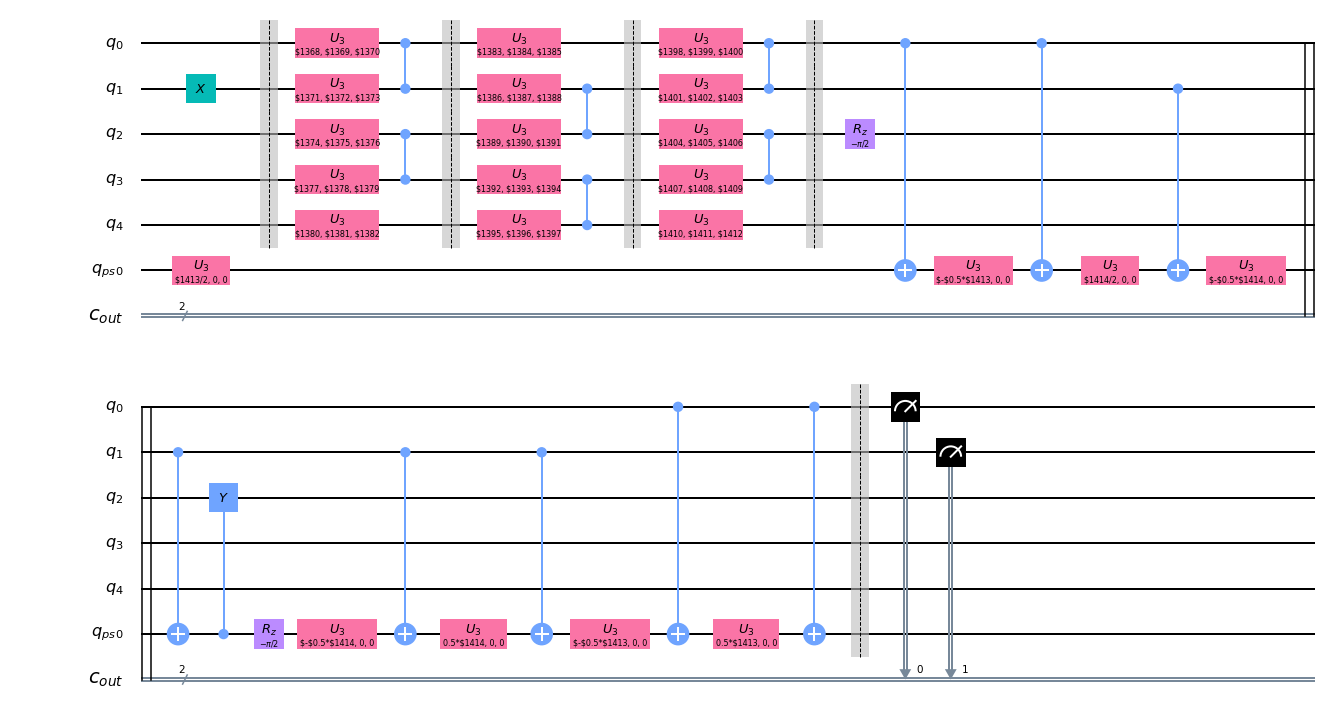

In [413]:
qcs = rvqe_cell(5, [0,1], 2, [0, 1], include_barriers=True)
(qcs[0] + qcs[1] + qcs[2]).draw(output="mpl")

Instead of executing the above circuit and repeating the RUS steps, and measuring the output in multiple parallel runs, we perform a "cheating" variant; noting that the cheating can be done efficiently.

In [199]:
def apply(qc: qc.QuantumCircuit, psi_init: Optional[qi.Statevector] = None) -> qi.Statevector:
    if psi_init is None:
        job = qk.execute(qc, backend=apply.backend, shots=1)
        return job.result()
    else:
        return psi_init.evolve(qc)
apply.backend = aer.StatevectorSimulator()

In [499]:
def rvqe_factory(width: int, u_layers: int, stages: int):
    # a sequence of unitary layers
    def u_layer():
        circ = unitary_layer(width)
        
        for l in range(u_layers):
            circ += entangling_layer(width, l%2)
            circ += unitary_layer(width)
            
        return circ
    
    # postselection layers; setup is like
    # [inlanes, out1, out2, p_anc]
    # and we alternate between writing to out1 and out2
    P_LAYER_WIDTH = width - 2
    def p_layer(evenodd: int):
        return postsel_gadget_layer(width, range(P_LAYER_WIDTH), P_LAYER_WIDTH + evenodd, add_measurement=False)
    
        
    # stages are always u then p
    stages = [ (u_layer(), p_layer(s%2)) for s in range(stages) ]
    param_count = sum([ u.num_parameters + p.num_parameters for u, p in stages ])
    
    
    def bind_stages(params: np.array) -> List[Tuple[qc.QuantumCircuit]]:
        ret = []
        idx = 0
        for u, p in stages:
            us = u.bind_parameters(dict(zip(u.parameters, params[idx : idx+u.num_parameters])))
            idx += u.num_parameters
            ps = p.bind_parameters(dict(zip(p.parameters, params[idx : idx+p.num_parameters])))
            idx += p.num_parameters
            ret.append((us, ps))
        return ret
        
    
    # return a list of parameters and a closure to execute
    def run(params: np.array, inputs: List[List[int]]):
        psi = rvqe_init(width)  # input state
        ls = bind_stages(params)  # specialize circuit with parameters
        output_probs = []
        outputs = []
        
        insize = len(inputs[0])
        assert insize <= width, "input too wide"
        previous_inpt = [0 for _ in range(insize)]
        for inpt in inputs:
            # pass input in
            psi.evolve(input_layer(width, inpt, previous_inpt))
            previous_input = inpt
            
            for u, p in ls:                
                # unitary and RUS circuit
                psi = psi.evolve(u + p)
                psi = postselect(psi, -1, 1)  # abbreviating the RUS application here
            
            # measure
            out, psi, probs = cheating_output_layer(psi, insize)
            outputs.append(out)
            output_probs.append(probs)
            
        return outputs, output_probs
    
    
    return (param_count, run)

In [500]:
param_count, run = rvqe_factory(6, 3, 10)
inputs = np.random.randint(2, size=(10, 3))
params = [ rand2pi() for _ in range(param_count) ]

In [501]:
%time run(params, inputs)

CPU times: user 2.06 s, sys: 109 ms, total: 2.17 s
Wall time: 2.13 s


(['001', '010', '111', '001', '001', '111', '101', '011', '111', '101'],
 [array([0.23574942, 0.15548401, 0.11464104, 0.06022139, 0.12692167,
         0.15722693, 0.05710562, 0.09264991]),
  array([0.05768501, 0.15943224, 0.18775722, 0.09342081, 0.10348129,
         0.13619301, 0.13235611, 0.12967433]),
  array([0.06670848, 0.04928954, 0.16804167, 0.1140519 , 0.14153517,
         0.11422966, 0.16940831, 0.17673529]),
  array([0.12999679, 0.13608655, 0.07733774, 0.11668538, 0.14225829,
         0.12226175, 0.1076348 , 0.1677387 ]),
  array([0.09442115, 0.14671749, 0.10360841, 0.12508739, 0.12274434,
         0.17254802, 0.15379089, 0.08108231]),
  array([0.18435671, 0.09576473, 0.17964641, 0.09565952, 0.06836781,
         0.10602486, 0.10212389, 0.16805608]),
  array([0.12189768, 0.18777673, 0.10307589, 0.12383001, 0.0924201 ,
         0.13644546, 0.13356083, 0.10099329]),
  array([0.12973973, 0.10945356, 0.15201948, 0.07407035, 0.10179163,
         0.12646337, 0.14131283, 0.16514907]),

# Training

an invalid character is the all 1s

In [532]:
def char_to_bin6(char: str) -> List[int]:
    try:
        idx = char_to_bin6.characters.index(char[0])
    except ValueError:
        idx = 2**6-1
    return char_to_bin6.lut[idx]
    
char_to_bin6.characters = [ c for c in "abcdefghijklmnopqrstuvwxyz0123456789 ,.!?-\"'" ]
char_to_bin6.lut = [
    [ int(c) for c in "{0:06b}".format(n) ] for n in range(2**6)
]

char_to_bin6("c")

[0, 0, 0, 0, 1, 0]

In [541]:
def char_to_bin5(char: str) -> List[int]:
    try:
        idx = char_to_bin5.characters.index(char[0])
    except ValueError:
        idx = 2**5-1
    return char_to_bin5.lut[idx]
    
char_to_bin5.characters = [ c for c in "abcdefghijklmnopqrstuvwxyz ,.!?" ]
char_to_bin5.lut = [
    [ int(c) for c in "{0:05b}".format(n) ] for n in range(2**5)
]

char_to_bin5("?")

[1, 1, 1, 1, 0]

In [543]:
def bin_to_onehot(lst: List[int], width: int) -> np.array:
    idx = int("".join(str(n) for n in lst), 2)
    ret = np.zeros(2**width)
    ret[idx] = 1.
    return ret

In [547]:
bin_to_onehot(char_to_bin5("?"), 5)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

## Training Sets

In [555]:
def constant_sentence(length: int, constant: List[int]) -> List[int]:
    return [ constant for _ in range(length) ]

In [556]:
def alternating_set(length: int, constants: List[List[int]]) -> List[int]:
    return [ constants[i % len(constants)] for i in range(length) ]

In [557]:
alternating_set(5, ["a", "b"])

['a', 'b', 'a', 'b', 'a']

## Optimize

In [571]:
from scipy.optimize import minimize

In [579]:
def crossentropy(target: np.array, predicted: np.array) -> float:
    return -sum(target * np.log(predicted))

In [580]:
crossentropy(np.array([1, 0, 0]), np.array([.9, .05, .05]))

0.10536051565782628

In [581]:
crossentropy(np.array([1, 0, 0]), np.array([.5, .25, .25]))

0.6931471805599453

In [573]:
def optim_step(fun, x0):
    res = minimize(fun, x0, method="L-BFGS-B", options={"maxiter": 10, "disp": False})
    return res.x, res.fun

In [574]:
param_count, rvqe = rvqe_factory(width=5, u_layers=2, stages=2)
param_count

96

In [575]:
EPOCHS = 20
SENTENCE_LENGTH = 10
gen = constant_set([1, 0])

params = np.array([ rand2pi() for _ in range(param_count) ])


epoch = 0
while epoch < EPOCHS:
    epoch += 1
    
    sentence = constant_sentence(SENTENCE_LENGTH, [1, 0])
    sentence_onehot = [ bin_to_onehot(s, len(sentence[0])) for s in sentence ]
    
    def fun(params: np.array) -> float:
        _, probs = rvqe(params, sentence)
        loss = sum(crossentropy(a, b) for a, b in zip(sentence_onehot, probs) )
        return loss
    
    params, loss = optim_step(fun, params)
    out, _ = rvqe(params, sentence)
    
    print(f"{epoch:03d}/{EPOCHS:03d}  {loss=:.3f} pred={' '.join(out)}")

KeyboardInterrupt: 